In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
from bnn_package import pos_nodes_uniform, connexion_normal_deterministic, add_passive_nodes, evolve_system,step_fhn_rk4, get_coupling_operator
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation
from matplotlib.colors import Normalize

import matplotlib
from IPython.display import HTML

%matplotlib widget

In [3]:
# ------------ Parameters ------------

#Seed
rng = np.random.default_rng(42)

# Graph parameters 
N_nodes = 1000
std = 0.25
mean = 0.0
(xmax, ymax) = (10.0, 10.0)
f = 3 # mean of the poisson of passive nodes per active node

# Evolution parameters : FN 
A = 3.          #0
alpha = 0.2     #1
Eps = 0.08      #2
K = 0.25        #3
V_RP = 1.5      #4
dt = 0.1        #5
params_FN = [A, alpha, Eps,  K,  V_RP, dt]

# Simulation parameters
T_max = 10000
C_r = 1.5
type_diff = "Laplacian"
# Initial conditions
State_0 = np.zeros((N_nodes, 3))
State_0[:, 0] = 0.1 + 0.1 * np.random.randn(N_nodes)  # v_e
State_0[:, 1] = 0.3 + 0.1 * np.random.randn(N_nodes)  # g
State_0[:, 2] = 1.0 + 0.1 * np.random.randn(N_nodes)

--- INFO ---
Active Nodes: 1000
Poisson Mean (f): 3
Total Passive nodes to be created: 3104
Plotting 1000 Active and 3104 Passive nodes.


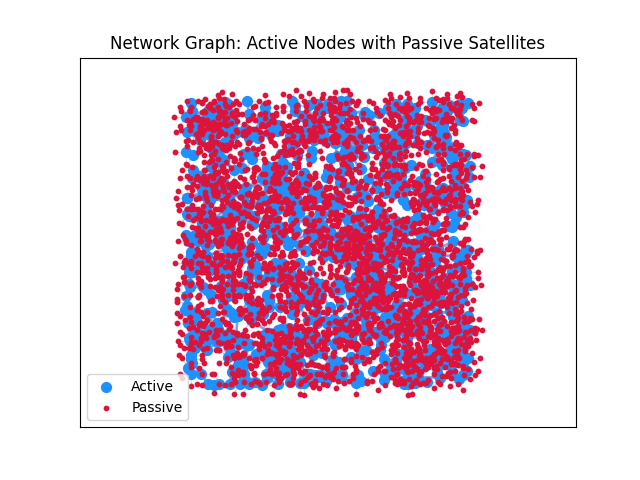

In [5]:
# ------------ 1. Build Graph & Fix Attributes ------------

# Generate active nodes
pos_nodes = pos_nodes_uniform(N_nodes, xmax, ymax, rng)
Adj = connexion_normal_deterministic(pos_nodes, rng, std)
G = nx.from_numpy_array(Adj)

# CRITICAL FIX: Tag original nodes as active immediately
nx.set_node_attributes(G, {node: "active" for node in G.nodes()}, name="type")

# Generate passive nodes
Graph_passive, N_p = add_passive_nodes(G, f, rng)

# Ensure passive nodes are tagged (if the function didn't do it)
for node in Graph_passive.nodes():
    if "type" not in Graph_passive.nodes[node]:
        Graph_passive.nodes[node]["type"] = "passive"

# ------------ 2. "Satellite" Positioning Logic ------------

pos = {}
radius = xmax * 0.04  # Distance of passive node from active node (adjust based on map size)

# A. Place Active Nodes first (Fixed positions)
active_nodes_list = [n for n, d in Graph_passive.nodes(data=True) if d.get("type") == "active"]
for i, node in enumerate(active_nodes_list):
    # Map numpy array index to node ID
    pos[node] = (pos_nodes[0, i], pos_nodes[1, i])

# B. Place Passive Nodes relative to their Active parent
# We iterate over active nodes to find their specific passive neighbors
for active_node in active_nodes_list:
    # Get all neighbors
    all_neighbors = list(Graph_passive.neighbors(active_node))
    # Filter for only passive neighbors
    passive_neighbors = [n for n in all_neighbors if Graph_passive.nodes[n].get("type") == "passive"]
    
    count = len(passive_neighbors)
    
    if count > 0:
        # Calculate angle step: 360 degrees divided by number of neighbors
        angle_step = (2 * math.pi) / count
        
        for i, passive_node in enumerate(passive_neighbors):
            # Calculate angle for this specific node
            theta = i * angle_step
            
            # Get parent (active) coordinates
            cx, cy = pos[active_node]
            
            # Calculate new position using trigonometry
            new_x = cx + radius * math.cos(theta)
            new_y = cy + radius * math.sin(theta)
            
            pos[passive_node] = (new_x, new_y)

# Handle any distinct passive nodes that might not have been connected (edge case)
for node in Graph_passive.nodes():
    if node not in pos:
        pos[node] = (0, 0) # Or random position

active_edges = []
passive_edges = []

for u, v in Graph_passive.edges():
    # Check the type of both nodes involved in the edge
    type_u = Graph_passive.nodes[u].get("type")
    type_v = Graph_passive.nodes[v].get("type")
    
    # If BOTH are active, it's an "Active-Active" connection
    if type_u == "active" and type_v == "active":
        active_edges.append((u, v))
    else:
        # Otherwise, it connects an active node to a passive satellite
        passive_edges.append((u, v))

# ------------ 3. Plotting ------------

fig, ax = plt.subplots()

# Get lists for plotting
active_nodes = [n for n, d in Graph_passive.nodes(data=True) if d.get("type") == "active"]
passive_nodes = [n for n, d in Graph_passive.nodes(data=True) if d.get("type") == "passive"]

print(f"Plotting {len(active_nodes)} Active and {len(passive_nodes)} Passive nodes.")

# 1. Draw Active-Active Edges (Specific color, e.g., Blue)
nx.draw_networkx_edges(
    Graph_passive,
    pos,
    edgelist=active_edges,
    width=2.0,              # Make them slightly thicker
    alpha=0.6,
    edge_color='royalblue', # <--- COLOR for active edges
    style='solid'
)

# 2. Draw Active-Passive Edges (Background color, e.g., Light Gray)
nx.draw_networkx_edges(
    Graph_passive,
    pos,
    edgelist=passive_edges,
    width=.5,
    alpha=0.3,
    edge_color='gray',      # <--- COLOR for satellite connections
    style='dashed'          # Optional: make them dashed to distinguish further
)

# Draw Edges first (so they are behind nodes)
nx.draw_networkx_edges(Graph_passive, pos, alpha=0.2, edge_color='gray')

# Draw Active Nodes (Blue, larger)
nx.draw_networkx_nodes(
    Graph_passive,
    pos,
    nodelist=active_nodes,
    node_color='dodgerblue',
    node_size=50,
    label='Active'
)

# Draw Passive Nodes (Red, smaller)
nx.draw_networkx_nodes(
    Graph_passive,
    pos,
    nodelist=passive_nodes,
    node_color='crimson',
    node_size=10,
    label='Passive'
)

ax.axis('equal') # Important to keep the "satellites" looking like circles, not ovals
ax.set_title("Network Graph: Active Nodes with Passive Satellites")
plt.legend()
plt.show()

Il faut ajuster la taille de la figure pour mieux voir le graphe et les edges

In [6]:
# 1. Prepare the Matrix (Standard Python/Numpy)

Coupling_Op = get_coupling_operator(Adj, type_diff)

# Ensure data types match for speed
Coupling_Op = Coupling_Op.astype(np.float64) 
State_0 = State_0.astype(np.float64)

# 2. Run the Simulation

Trajectory = evolve_system(
    State_0, 
    T_max, 
    params_FN, 
    step_fhn_rk4, 
    N_p, 
    Coupling_Op, 
    C_r, 
    type_diff
)

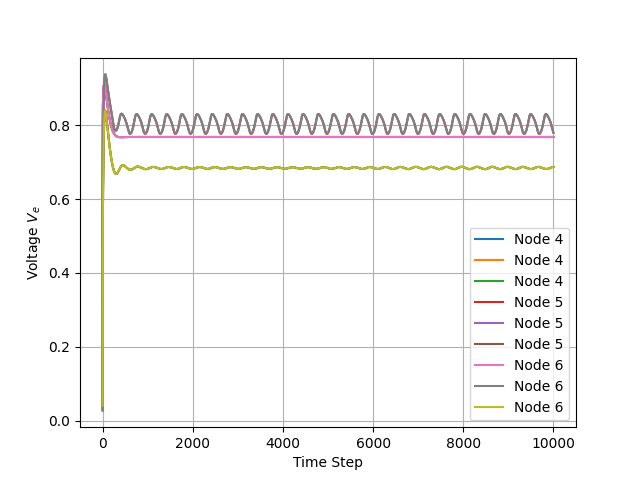

[[0.21588232 0.02796189 0.04087168]
 [0.47844621 0.33778663 0.20726204]
 [0.63515684 0.49700522 0.3200164 ]
 [0.72738124 0.5832963  0.39900886]
 [0.78085855 0.63270059 0.4556648 ]
 [0.81212965 0.66356311 0.49731894]
 [0.83111988 0.68512581 0.52887472]]


In [7]:
# ------------ Some plot of some nodes ---------------
fig, ax = plt.subplots()
v_e = Trajectory[:, 4:7, 0]
ax.plot( np.arange(len(v_e[:,0])),v_e,label=f'Node {4}')
ax.plot( np.arange(len(v_e[:,1])),v_e,label=f'Node {5}')
ax.plot( np.arange(len(v_e[:,2])),v_e,label=f'Node {6}')

ax.set_xlabel('Time Step')
ax.set_ylabel('Voltage $V_e$')
ax.legend()
ax.grid(True)
plt.show()
print(v_e[:7,:])

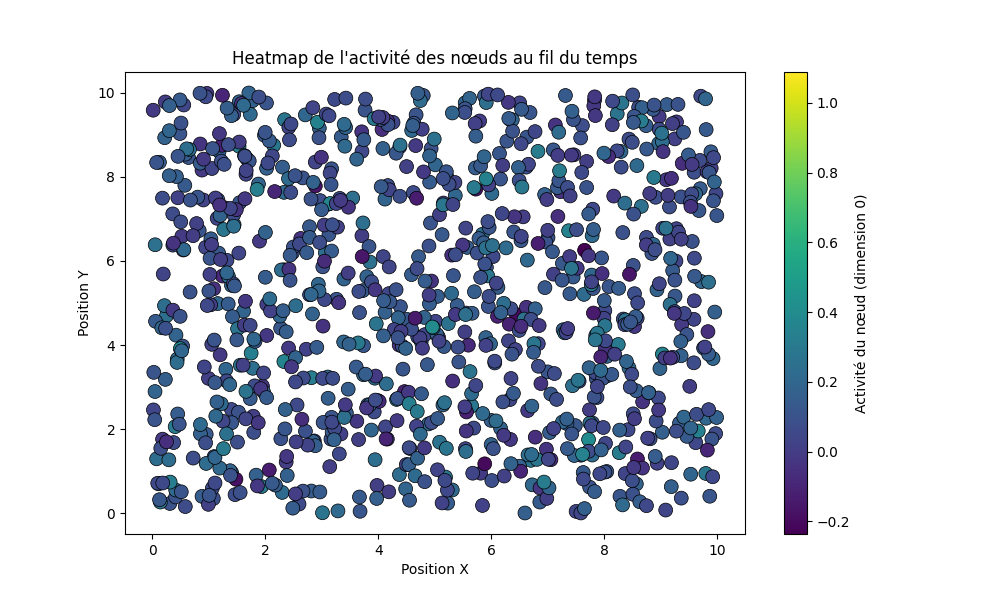

"\n# ------------ Sauvegarde de la vidéo (optionnel) ------------\n# Nécessite ffmpeg: brew install ffmpeg\nanim.save(\n    'node_activity_heatmap.mp4',\n    writer='ffmpeg',\n    fps=20,\n    dpi=150\n)\n"

In [10]:
activity = Trajectory[:, :, 0]  # Forme (T, N)

# Positions des nœuds (pos est un dictionnaire {node: (x, y)})
nodes = list(pos.keys())
# Extract the number of nodes that actually exist in your simulation data
N_simulated = activity.shape[1]  # Should be 1000 based on your error

# Create lists of positions ONLY for the nodes present in the trajectory
# We assume the simulation corresponds to node indices 0 to 999
x_pos = [pos[i][0] for i in range(N_simulated)]
y_pos = [pos[i][1] for i in range(N_simulated)]

# Normalisation des valeurs pour la colormap
norm = Normalize(vmin=activity.min(), vmax=activity.max())

# ------------ Initialisation de la figure ------------
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    x_pos, y_pos,
    c=activity[0, :],  
    cmap='viridis',    
    norm=norm,
    s=100,             
    edgecolor='k',     
    linewidth=0.5
)

# Ajouter une colorbar pour la légende
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Activité du nœud (dimension 0)')

# Titre et labels
ax.set_title('Heatmap de l\'activité des nœuds au fil du temps')
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')

# ------------ Fonction de mise à jour pour l'animation ------------
def update(frame):
    """Met à jour les couleurs des points pour la frame donnée."""
    scatter.set_array(activity[frame*4, :])  # Met à jour les couleurs
    ax.set_title(f'Heatmap - Temps = {frame}')
    return scatter,

# ------------ Création de l'animation ------------
n_frames = activity.shape[0]//4

# Créer l'animation
anim = animation.FuncAnimation(
    fig,
    update,
    frames=n_frames,
    interval=10,  # 50ms between frames (20 fps)
    blit=True,
    repeat=False
)

plt.show()

'''
# ------------ Sauvegarde de la vidéo (optionnel) ------------
# Nécessite ffmpeg: brew install ffmpeg
anim.save(
    'node_activity_heatmap.mp4',
    writer='ffmpeg',
    fps=20,
    dpi=150
)
'''